# U-Net Image Creation

## modules and data

In [1]:
# import modules

# basics
import os, glob, sys
import warnings
import time
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import gaussian_kde

from scipy import ndimage

In [2]:
ground = np.load('../ground_06_new.npy')
xz_icesat = np.load('../xz_icesat_new.npy')

## study site segmentation

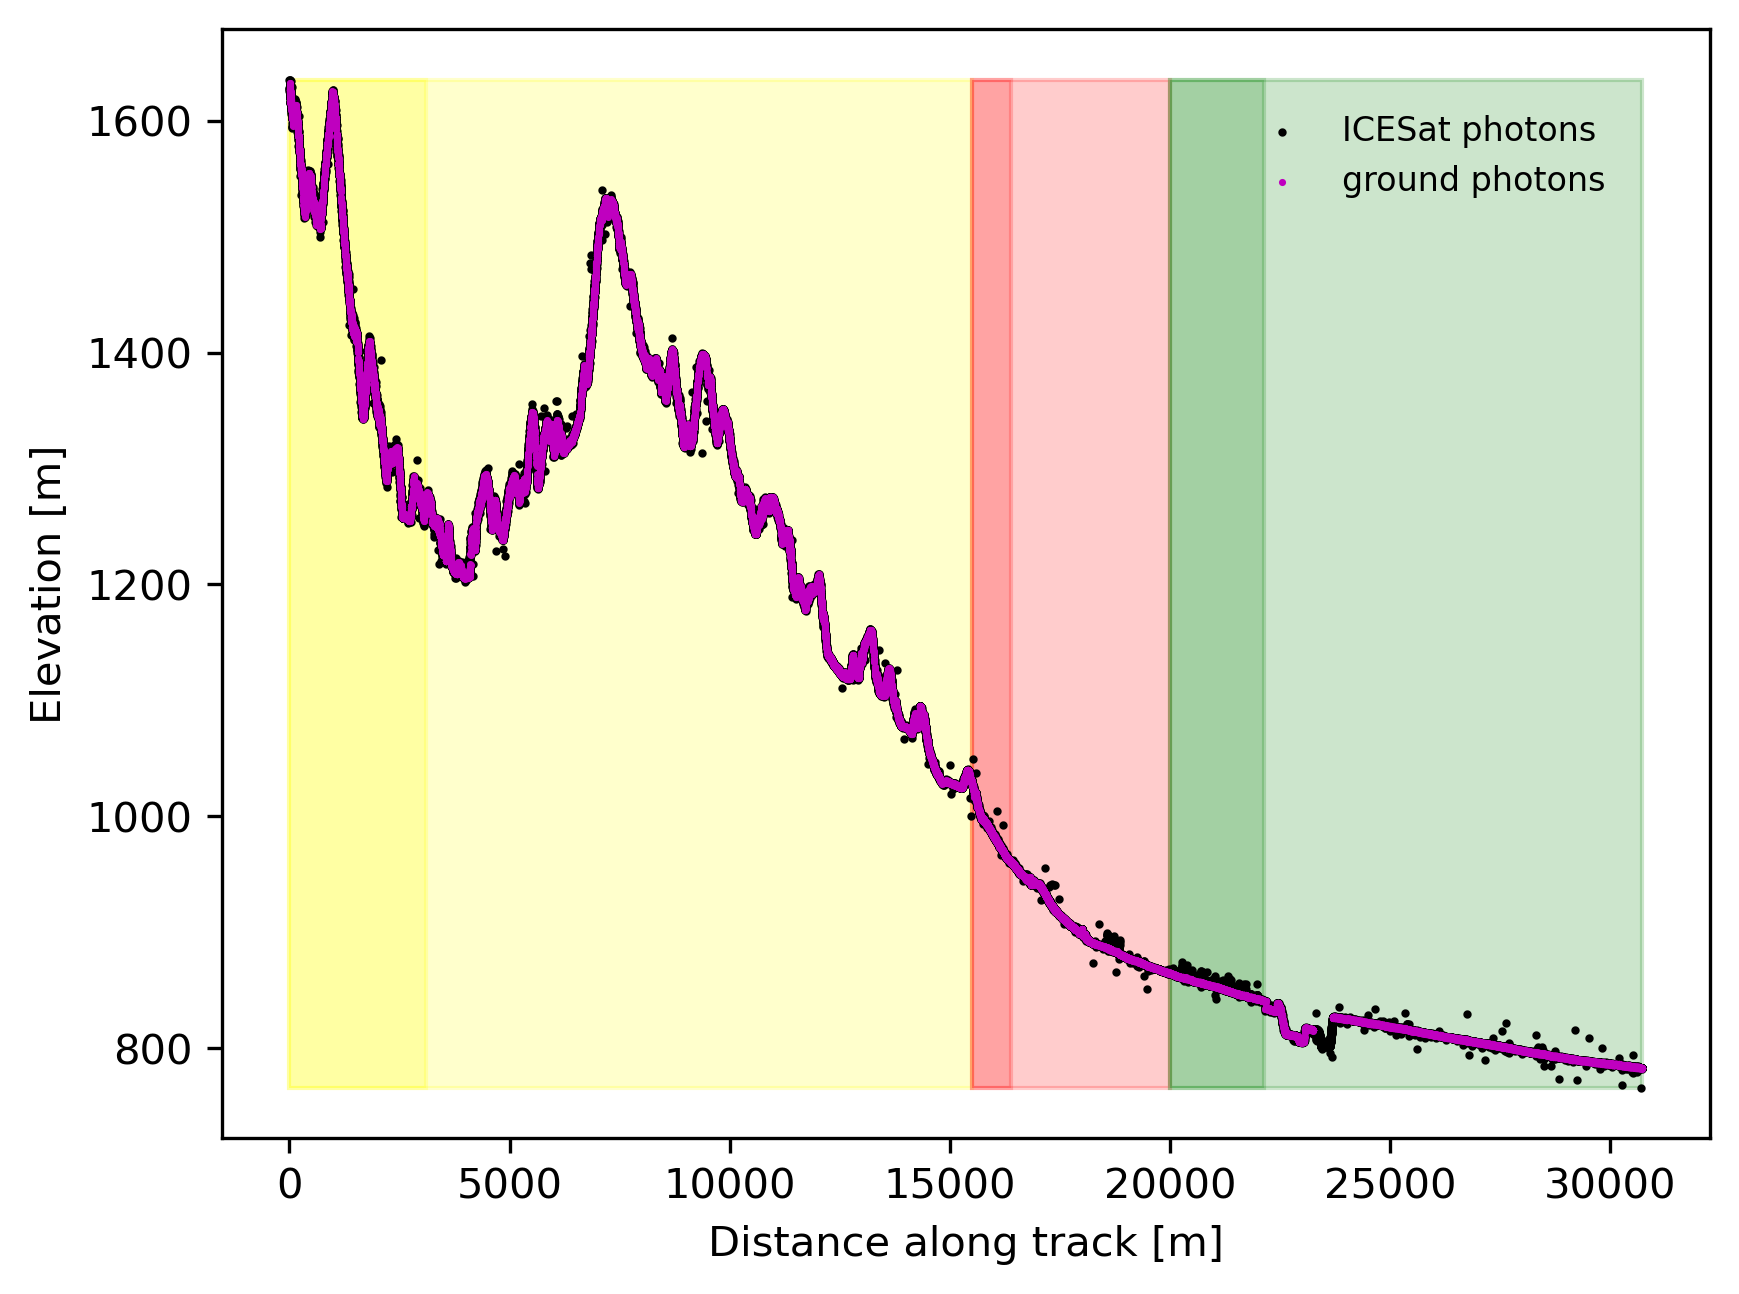

In [10]:
from matplotlib import patches

fig, ax = plt.subplots()
fig.set_dpi(300)

rect1 = patches.Rectangle((0,xz_icesat[:,1].min()), 15500, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='yellow', alpha=0.2);
ax.add_patch(rect1);
rect11 = patches.Rectangle((0,xz_icesat[:,1].min()), 3100, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='yellow', alpha=0.2);
ax.add_patch(rect11);

rect2 = patches.Rectangle((15500,xz_icesat[:,1].min()), 4500, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='red', alpha=0.2);
ax.add_patch(rect2);
rect22 = patches.Rectangle((15500,xz_icesat[:,1].min()), 900, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='red', alpha=0.2);
ax.add_patch(rect22);

rect3 = patches.Rectangle((20000,xz_icesat[:,1].min()), xz_icesat[-1,0]-20000, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='green', alpha=0.2);
ax.add_patch(rect3);
rect3 = patches.Rectangle((20000,xz_icesat[:,1].min()), 2145, xz_icesat[:,1].max()-xz_icesat[:,1].min(), color='green', alpha=0.2);
ax.add_patch(rect3);

ax.scatter(xz_icesat[:,0], xz_icesat[:,1], c='k', s=1, label='ICESat photons');
ax.scatter(xz_icesat[ground,0], xz_icesat[ground,1], c='m', s=0.5, label='ground photons');

ax.set_ylabel('Elevation [m]')
ax.set_xlabel('Distance along track [m]')
ax.legend(fontsize=8, frameon=False, loc='upper right', bbox_to_anchor=(0.95,0.95));
plt.savefig('swath_regions.png', bbox_inches='tight')

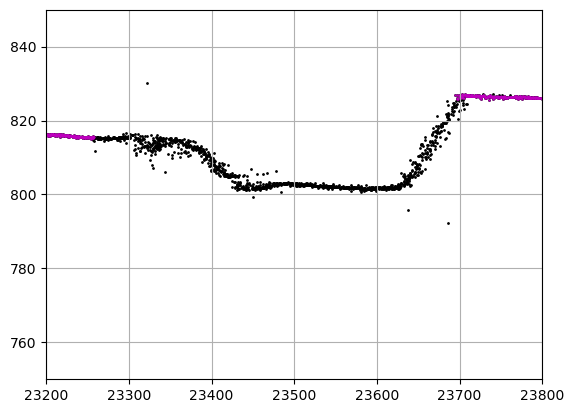

In [4]:
# quarry visualization
fig, ax = plt.subplots()
ax.scatter(xz_icesat[:,0], xz_icesat[:,1], c='k', s=1);
ax.scatter(xz_icesat[ground,0], xz_icesat[ground,1], c='m', s=0.5);
ax.set_xlim(23200,23800);
ax.set_ylim(750,850);
ax.grid();

In [3]:
# define bounds of quarry
invalid_ALS_lower = 23250
invalid_ALS_upper = 23700

## image .npz's

In [2]:
def global_histogram_npz(lower_x, upper_x, landscape_name, scaling_exception, EDTval=2, px_resolution=128, m_resolution=128, stepsize=128, scaling=1, save=False):

    start = time.time()
    # define resolution for histogram/KDE plots
    resolution = m_resolution/px_resolution
    # catch empty bins
    empty_subsets = []

    edt_train = []
    kde_train = []
    edt_label = []
    kde_label = []

    invalid_ALS_lower = 23250
    invalid_ALS_upper = 23700

    # define array to iterate over
    it_array = np.arange(lower_x, upper_x-m_resolution, stepsize)
    # delete values at the area where ALS data was invalid (adjusted for resolution)
    invalid_ALS = np.arange(invalid_ALS_lower-m_resolution,invalid_ALS_upper+m_resolution)
    it_array_new = np.setdiff1d(it_array,invalid_ALS)
    # delete elements listed in scaling_exception (if any)
    it_array_new = np.delete(it_array_new, scaling_exception)
    if (scaling == 1 & save == True):
        np.save(f'it_array_{landscape_name}_{m_resolution}.npy', it_array_new)

    if len(it_array_new) > 0:
        for count, i in enumerate(it_array_new):
            # subset the icesat beam and apply scaling factor
            sub_ii, = np.where((xz_icesat[:,0] >= i) & (xz_icesat[:,0] < i+m_resolution))
            subset = xz_icesat[sub_ii]
            subset[:,1] = subset[:,1] * scaling

            # x and z direction offset values to center the all-photon subset around (0,0)
            # also applied to ground photons 
            xr = int(subset[:,0].max()-(subset[:,0].max()-subset[:,0].min())/2)
            zr = int(subset[:,1].max()-(subset[:,1].max()-subset[:,1].min())/2)

            # derive ground photons
            ground_ii, = np.where((xz_icesat[ground,0] >= i) & (xz_icesat[ground,0] < i+m_resolution))
            subset_g = xz_icesat[ground[ground_ii]]
            subset_g[:,1] = subset_g[:,1] * scaling
            
            # if there are more than 2 points in the ground subset (KDE fails otherwise)
            if len(subset_g) > 2:
                # if the extent in z is not larger than the resolution, proceed
                if (subset[:,1].max()-subset[:,1].min()) < m_resolution:
                    
                    # TRAINING
                    # center the photons around (0,0)
                    x = subset[:,0] - xr
                    z = subset[:,1] - zr
                    
                    # EDT
                    # make histogram bin edges
                    halfres = int(m_resolution/2)
                    int_bins = [np.arange(-halfres, halfres+resolution, resolution), np.arange(-halfres, halfres+resolution, resolution)]
                    # calculate histogram and rotate
                    hist,_,_ = np.histogram2d(x, z, int_bins)
                    hist = np.rot90(hist, 1)
                    # calculate EDT and invert
                    D = ndimage.distance_transform_edt(~(hist > 0))
                    D = np.abs(D-D.max())
                    # normalize training input EDT, square if needed
                    D = D**2
                    D = D/D.max()
                    edt_train.append(D)

                    # KDE
                    ix, iy = np.meshgrid(np.arange(-halfres, halfres, resolution), np.arange(-halfres, halfres, resolution))
                    icoords = np.c_[ix.ravel(), iy.ravel()].T
                    kde = gaussian_kde(np.c_[x, z].T)
                    kde_im = kde(icoords).reshape(ix.shape)
                    kde_im = np.flipud(kde_im)
                    # normalize training input KDE
                    kde_im  = kde_im/kde_im.max()
                    kde_train.append(kde_im)


                    # LABEL
                    # center the photons around (0,0)
                    x = subset_g[:,0] - xr
                    z = subset_g[:,1] - zr
                    
                    # EDT
                    hist,_,_ = np.histogram2d(x, z, int_bins)
                    hist = np.rot90(hist, 1)
                    D_g = ndimage.distance_transform_edt(~(hist > 0))
                    labels_edt = (D_g < EDTval).astype(int)
                    # binary operations
                    struct2 = ndimage.generate_binary_structure(2,1)
                    labels_edt = ndimage.binary_closing(labels_edt, structure=struct2, iterations=3).astype(int)
                    edt_label.append(labels_edt)



                    # KDE
                    kde = gaussian_kde(np.c_[x, z].T)
                    labels_g = kde(icoords).reshape(ix.shape)
                    labels_g = np.flipud(labels_g)
                    labels_p = (labels_g > np.percentile(labels_g, 80))
                    labels_kde = labels_p.astype(int)
                    kde_label.append(labels_kde) 

                    # plot
                    if save==False:    
                        fig, ax = plt.subplots(2,2, figsize=(9,9))
                        ax = ax.ravel()
                        fig.set_dpi(300)
                        ax[0].imshow(labels_edt);
                        ax[0].set_title('EDT label')
                        ax[1].imshow(labels_kde);
                        ax[1].set_title('KDE label')#
                        im1 = ax[2].imshow(D, extent=(0, 128, 128, 0));
                        ax1_divider = make_axes_locatable(ax[2])
                        cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
                        cb1 = fig.colorbar(im1, cax=cax1)
                        ax[2].imshow(labels_edt, extent=(0, 128, 128, 0), cmap='magma_r', alpha=0.2)
                        ax[2].scatter((x+int(m_resolution/2))/resolution,px_resolution-(z/resolution+int(px_resolution/2)), s=0.5, label='ground', alpha=0.2, c='r')
                        ax[2].set_title('EDT (inverted) + EDT label + ground photons')
                        im2 = ax[3].imshow(kde_im, extent=(0, 128, 128, 0));
                        ax2_divider = make_axes_locatable(ax[3])
                        cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
                        cb2 = fig.colorbar(im2, cax=cax2)
                        ax[3].imshow(labels_edt, extent=(0, 128, 128, 0), cmap='magma_r', alpha=0.2)
                        ax[3].set_title('KDE')
                        #ax[5].set_visible(False)
                        fig.suptitle(f'Resolution: {px_resolution} px, coverage: {m_resolution} m, EDT = {EDTval}')
                else:
                    print('Error: scaled y exceeds resolution')
                    empty_subsets.append(count) 
                    edt_train.append(np.zeros((px_resolution, px_resolution)))
                    kde_train.append(np.zeros((px_resolution, px_resolution)))
                    edt_label.append(np.zeros((px_resolution, px_resolution)))
                    kde_label.append(np.zeros((px_resolution, px_resolution)))
                    #union_label.append(np.zeros((px_resolution, px_resolution)))
            else:
                print('Error: subset too small for KDE')
                empty_subsets.append(count)
                edt_train.append(np.zeros((px_resolution, px_resolution)))
                kde_train.append(np.zeros((px_resolution, px_resolution)))
                edt_label.append(np.zeros((px_resolution, px_resolution)))
                kde_label.append(np.zeros((px_resolution, px_resolution)))
                #union_label.append(np.zeros((px_resolution, px_resolution)))

        print(f'No of iterations: {len(edt_label)}')
        print(f'No of not working subsets: {len(empty_subsets)}')
    
        if save==True:
            # save indices of empty subsets
            np.save(f'empty_{landscape_name}_{m_resolution}_{scaling}.npy', empty_subsets)

            # gather everything in npz file
            # label
            edt_label = np.array(edt_label, dtype="int")
            edt_label = np.delete(edt_label, empty_subsets, axis=0)
            edt_label = np.expand_dims(edt_label, axis=-1)

            kde_label = np.array(kde_label, dtype="int")
            kde_label = np.delete(kde_label, empty_subsets, axis=0)
            kde_label = np.expand_dims(kde_label, axis=-1)
            
            patch_label_all = np.stack((edt_label, kde_label), axis=3)
            patch_label_all = np.squeeze(patch_label_all)
            print(f'Shape label = {patch_label_all.shape}')

            # train
            edt_train = np.array(edt_train)
            edt_train = np.delete(edt_train, empty_subsets, axis=0)
            edt_train = np.expand_dims(edt_train, axis=-1)

            kde_train = np.array(kde_train)
            kde_train = np.delete(kde_train, empty_subsets, axis=0)
            kde_train = np.expand_dims(kde_train, axis=-1)

            patch_train_all = np.stack((edt_train, kde_train), axis=3)
            patch_train_all = np.squeeze(patch_train_all)
            print(f'Shape train = {patch_train_all.shape}')
            
            # save to npz
            if scaling != 1:
                np.savez_compressed(f"{landscape_name}_train_label_EDT{EDTval}_{lower_x}_{upper_x}_res{m_resolution}_scale{scaling}_s{stepsize}", label=patch_label_all, train=patch_train_all)
            else:
                np.savez_compressed(f"{landscape_name}_train_label_EDT{EDTval}_{lower_x}_{upper_x}_res{m_resolution}_s{stepsize}", label=patch_label_all, train=patch_train_all)

    end = time.time()
    print(f'Runtime: {end - start:.1f} s')
    return empty_subsets

In [45]:
for k in np.arange(2,6):
    empty_subs = global_histogram_npz(0, int(xz_icesat[-1,0]), 'all_squared_scaled_binary', scaling_exception=[], EDTval=k, px_resolution=128, m_resolution=64, stepsize=5, scaling=1, save=True)

Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exceeds resolution
Error: scaled y exce

No of iterations: 1
No of not working subsets: 0
Runtime: 0.1 s


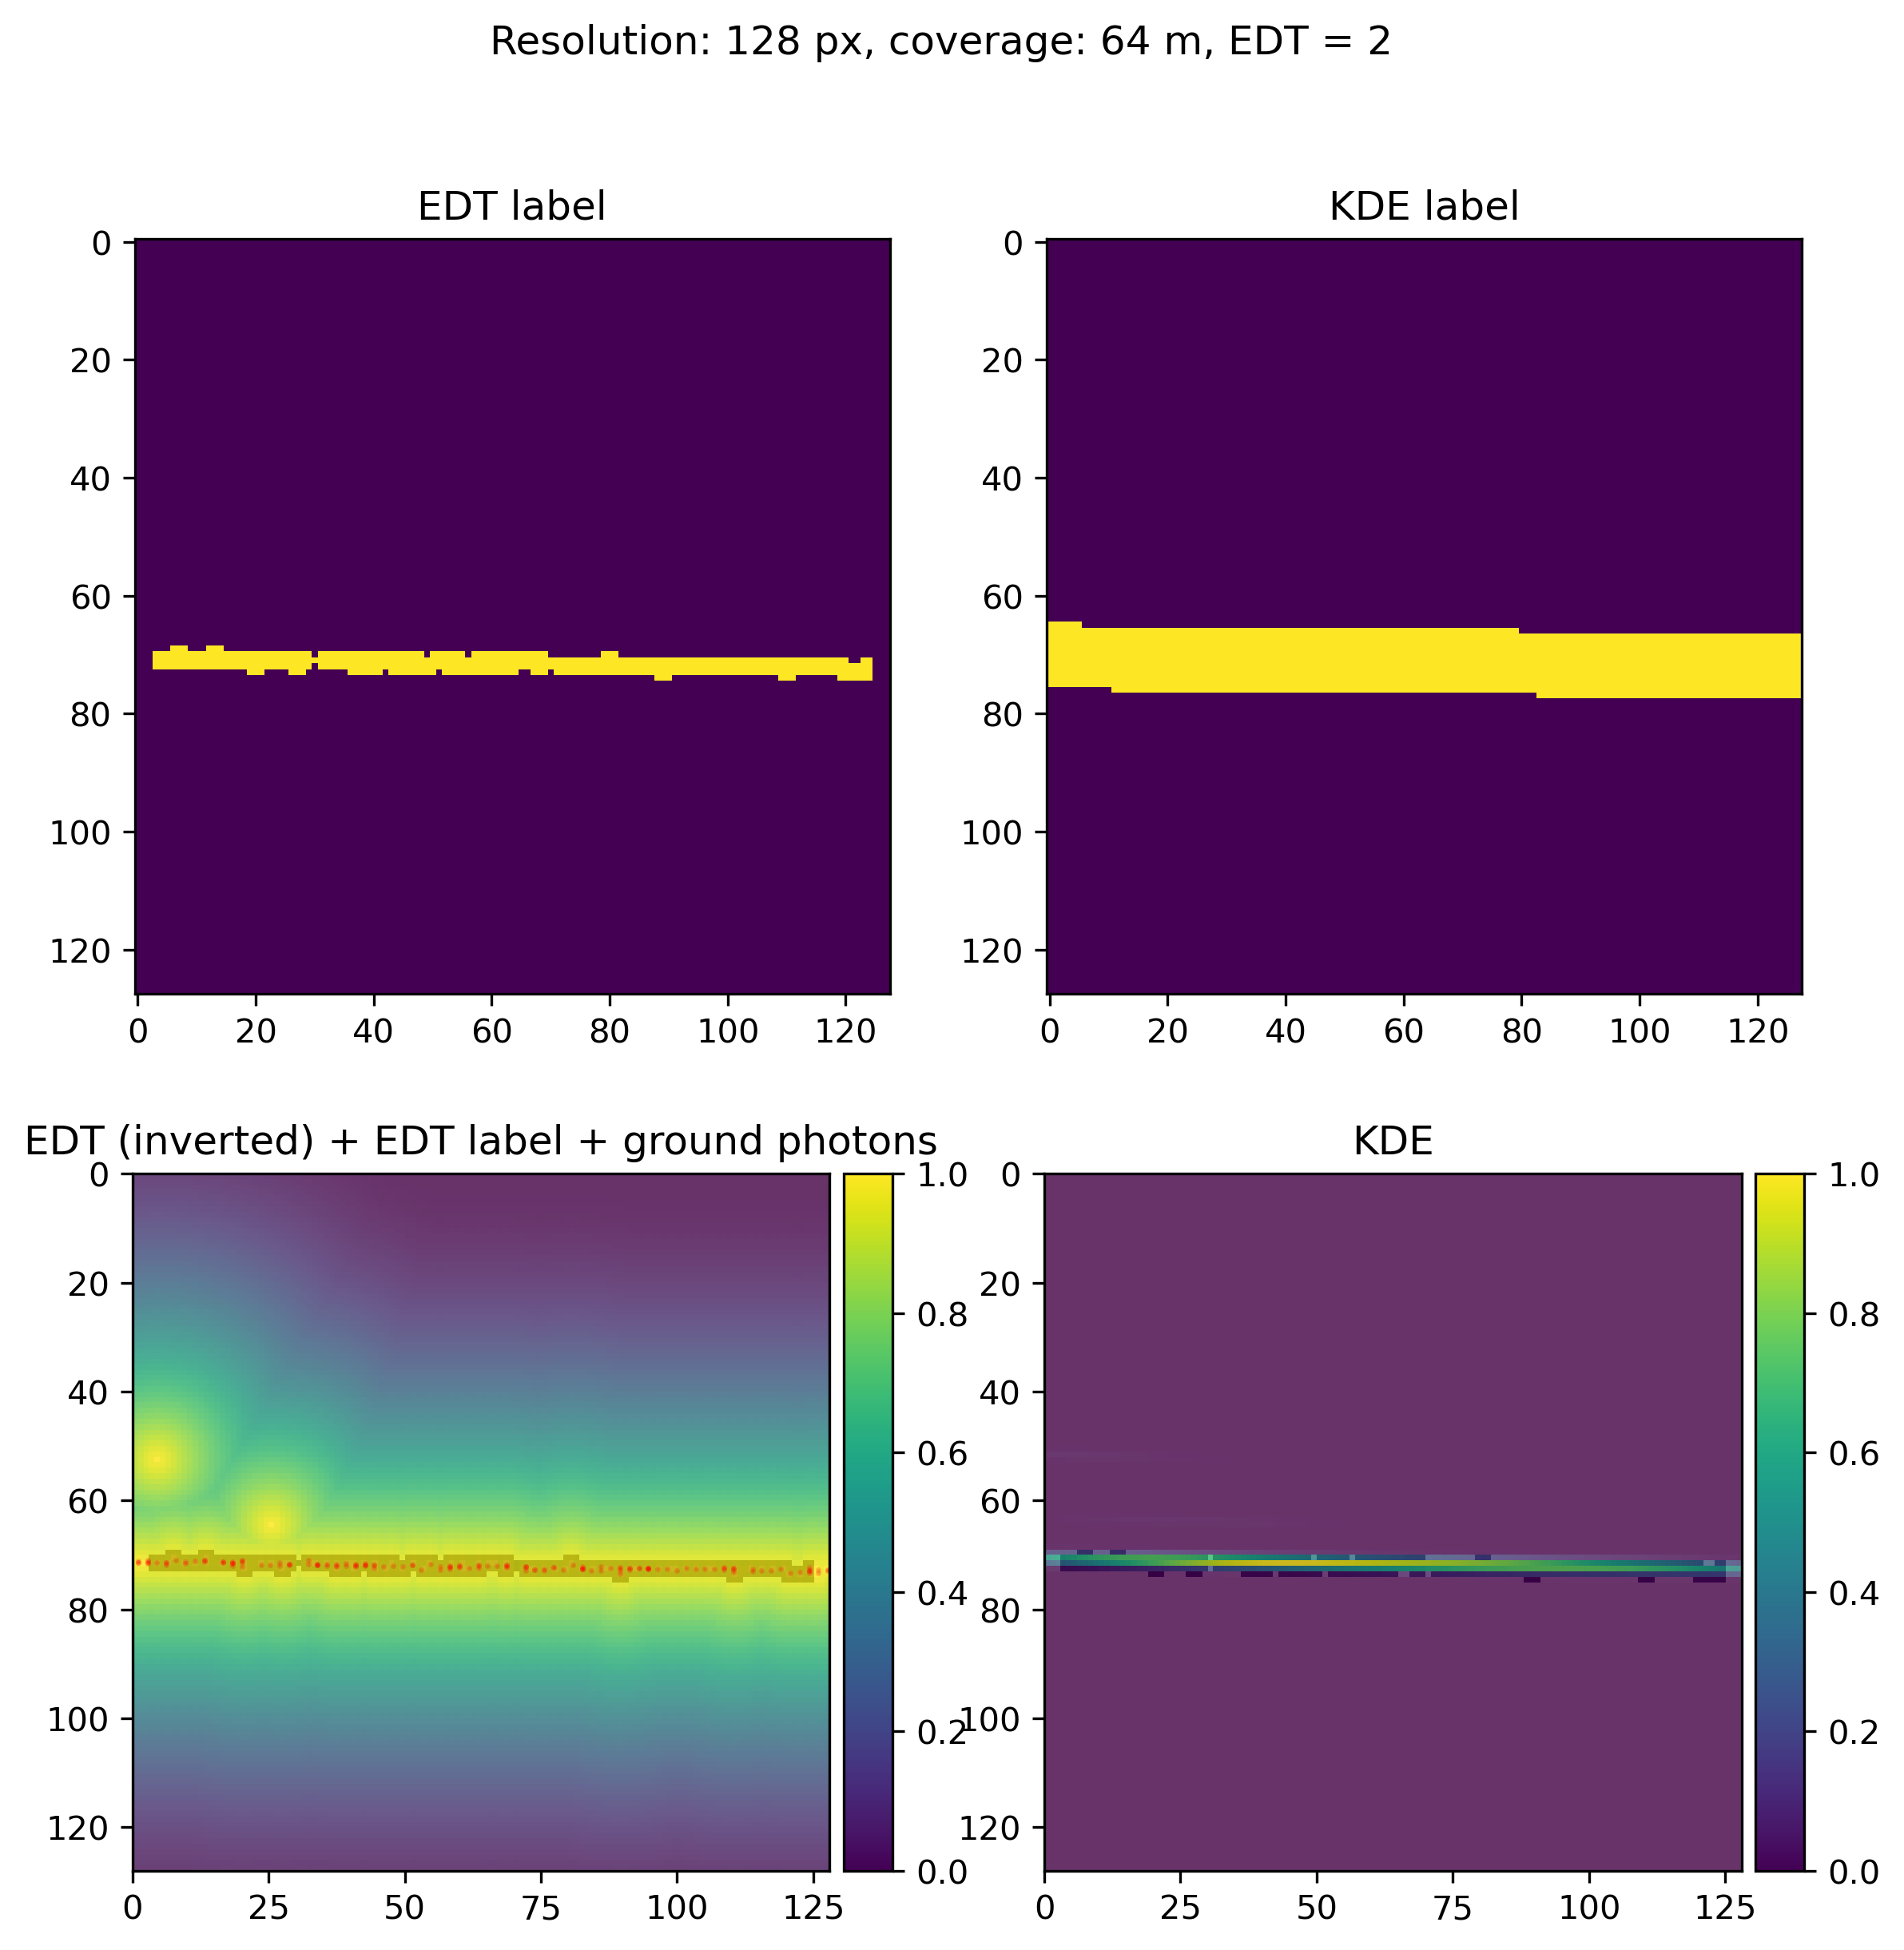

In [6]:
empty_subs = global_histogram_npz(21570, 21634+2, 'all', scaling_exception=[], EDTval=2, px_resolution=128, m_resolution=64, stepsize=5, scaling=1, save=False)

No of iterations: 1
No of not working subsets: 0
Runtime: 0.1 s


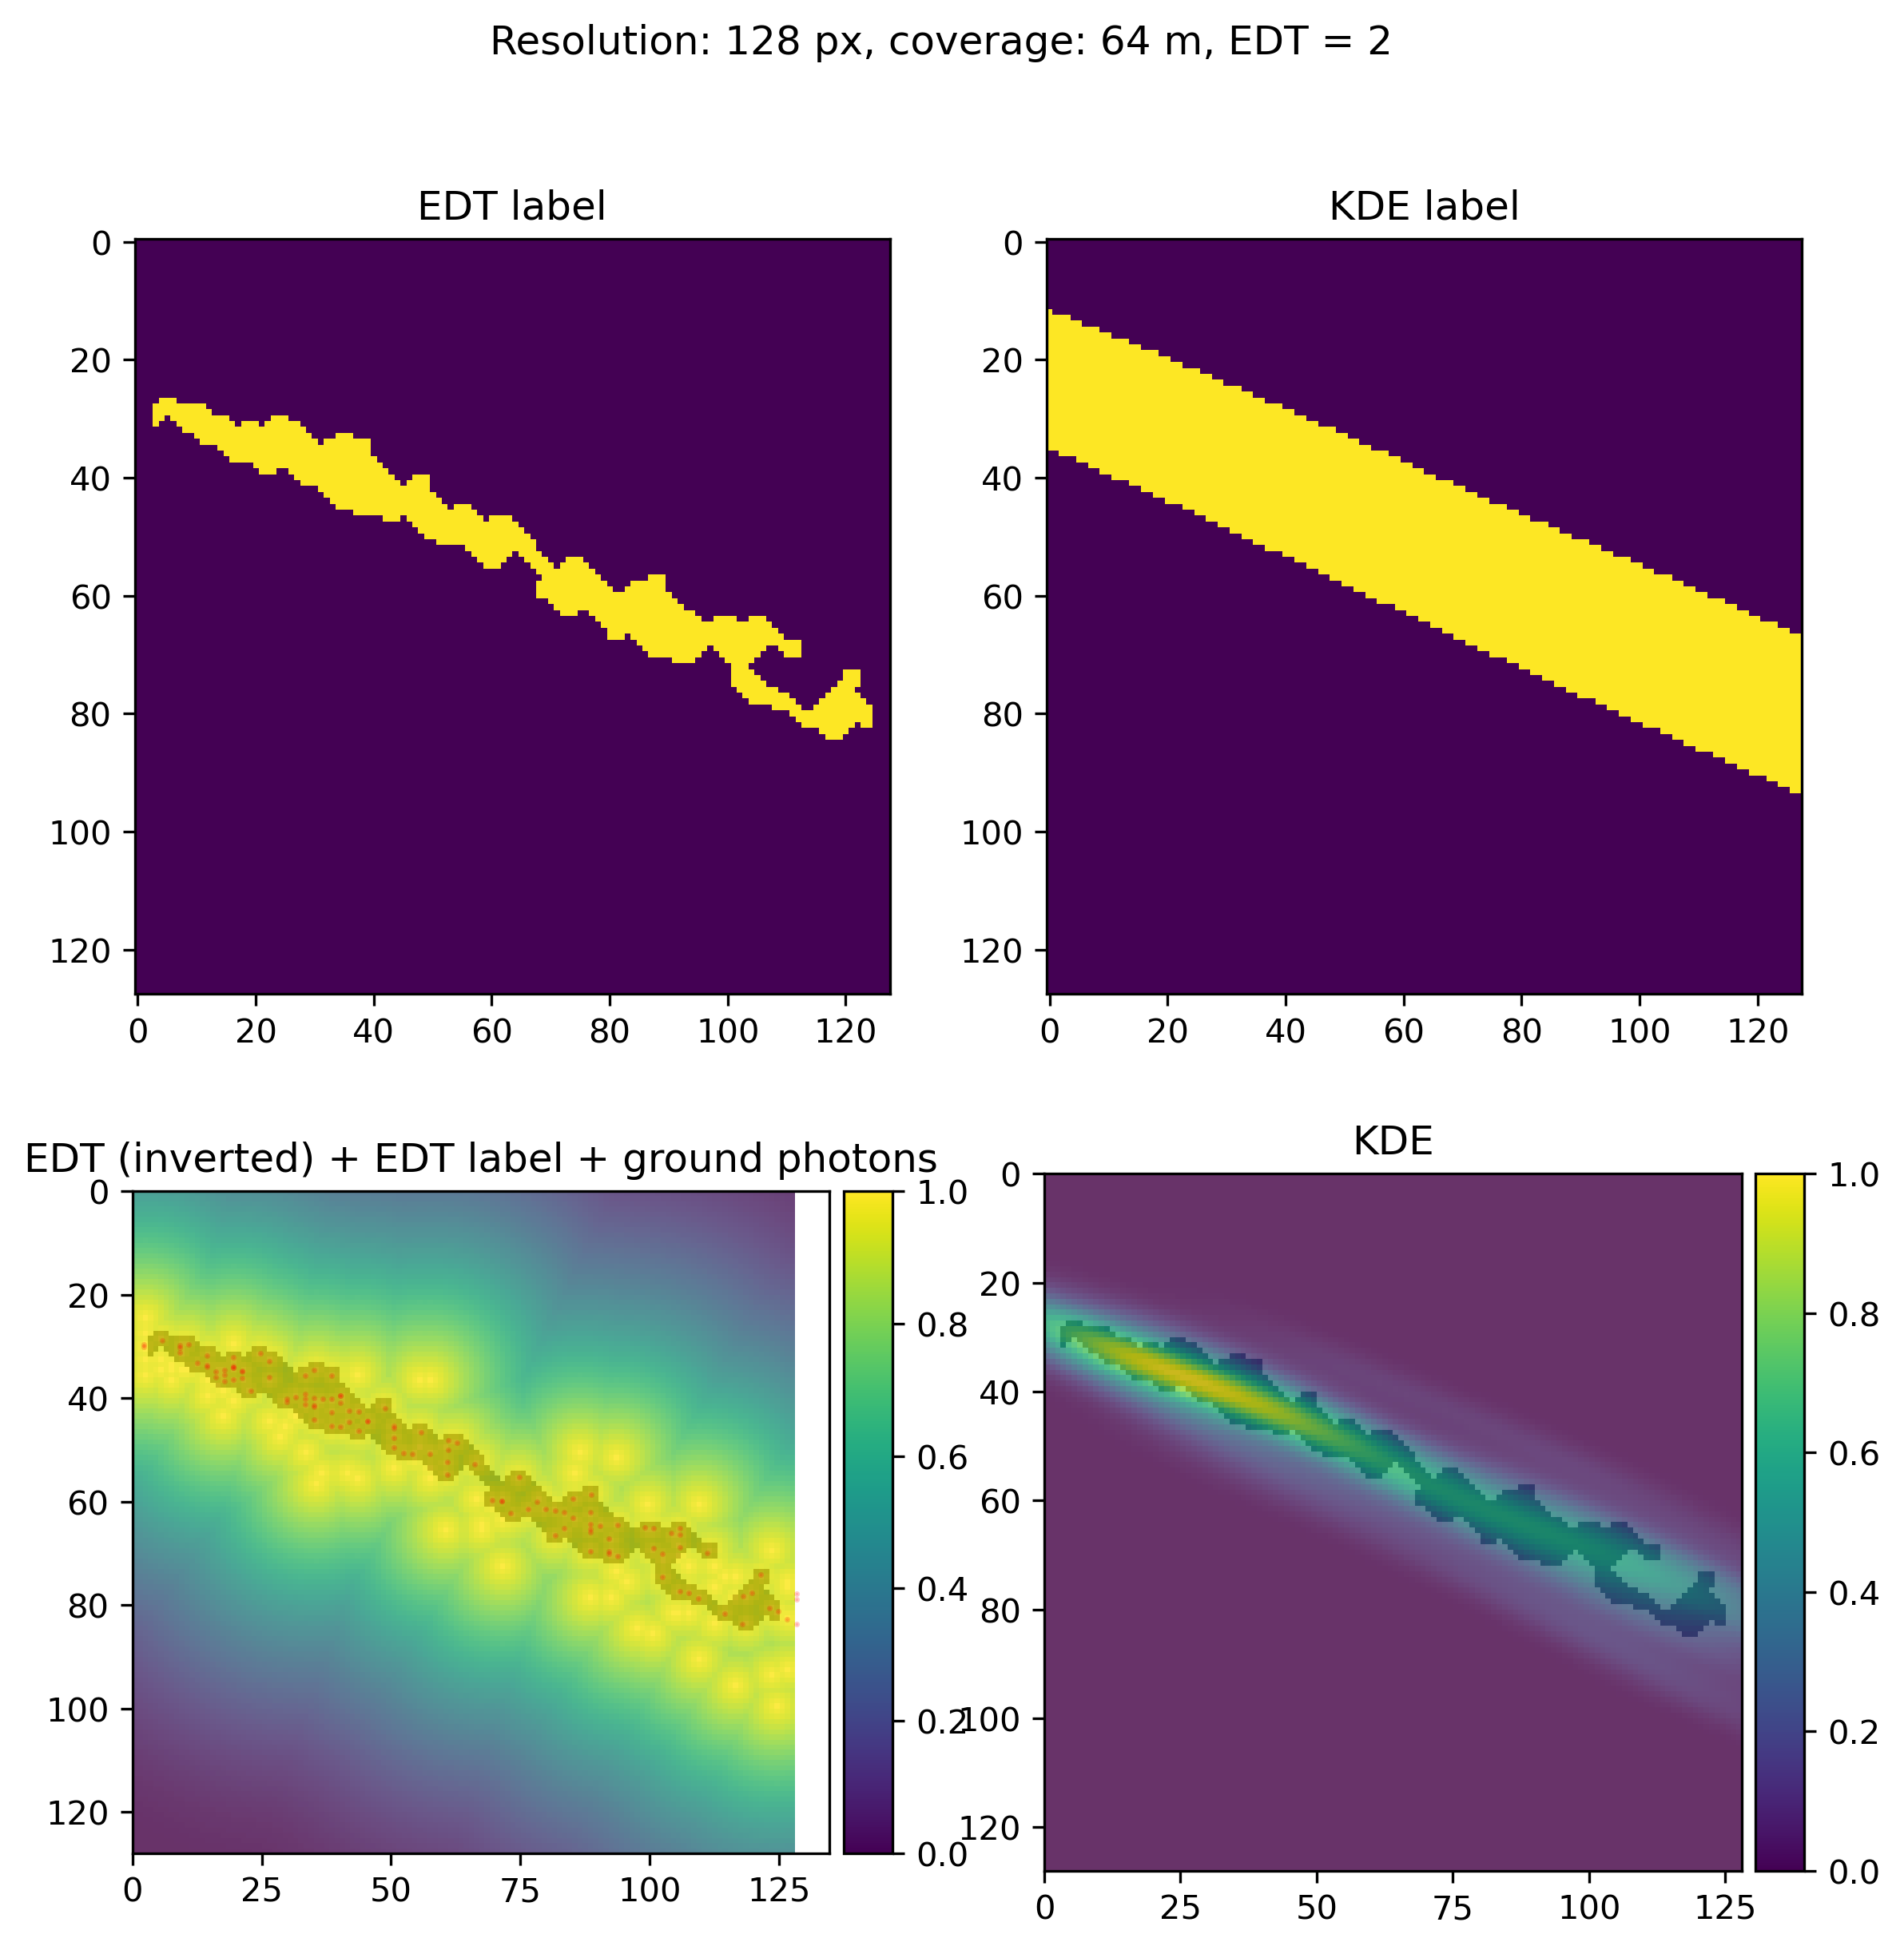

In [9]:
empty_subs = global_histogram_npz(1000, 1064+2, 'all', scaling_exception=[], EDTval=2, px_resolution=128, m_resolution=64, stepsize=5, scaling=1, save=False)

## make training & test npz's

In [3]:
empty_subs = np.load('empty_all_64_1.npy')
arr = np.load('it_array_all_64.npy')
if empty_subs.shape[0] > 0:
    arr = np.delete(arr, empty_subs)
arr

array([    0,     5,    10, ..., 30650, 30655, 30660])

In [4]:
for k in np.arange(2,6):
    data = np.load(f'all_scaled_squared_train_label_EDT{k}_0_30726_res64_s5.npz')
    
    # split all feature input data and labels by landscape and then by 20%/80% threshold to make training and testing data
    data_label = data['label']
    data_train = data['train']
    
    cutoff_mtns = np.where((arr >= 15500) & (arr < 20000))[0][0]
    cutoff_fhills = np.where((arr >= 20000) & (arr < xz_icesat[-1,0]))[0][0]
    
    # mtns
    data_mtns_label = data_label[:cutoff_mtns]
    data_mtns_train = data_train[:cutoff_mtns]
    thr1 = int(data_mtns_label.shape[0] / 5)
    x_train_mtns, x_test_mtns, y_train_mtns, y_test_mtns = (data_mtns_train[thr1:], data_mtns_train[:thr1], data_mtns_label[thr1:], data_mtns_label[:thr1],)
    
    # fhills
    data_fhills_label = data_label[cutoff_mtns:cutoff_fhills]
    data_fhills_train = data_train[cutoff_mtns:cutoff_fhills]
    thr2 = int(data_fhills_label.shape[0] / 5)
    x_train_fhills, x_test_fhills, y_train_fhills, y_test_fhills = (data_fhills_train[thr2:], data_fhills_train[:thr2], data_fhills_label[thr2:], data_fhills_label[:thr2],)
    
    # plains
    data_plains_label = data_label[cutoff_fhills:]
    data_plains_train = data_train[cutoff_fhills:]
    thr3 = int(data_plains_label.shape[0] / 5)
    x_train_plains, x_test_plains, y_train_plains, y_test_plains = (data_plains_train[thr3:], data_plains_train[:thr3], data_plains_label[thr3:], data_plains_label[:thr3],)
    
    # concat
    x_train = np.concatenate((x_train_mtns,x_train_fhills,x_train_plains))
    x_test =  np.concatenate((x_test_mtns, x_test_fhills, x_test_plains ))
    y_train = np.concatenate((y_train_mtns,y_train_fhills,y_train_plains))
    y_test =  np.concatenate((y_test_mtns, y_test_fhills, y_test_plains ))
    
    #np.savez_compressed(f"all_scaled_squared_EDT{k}_res64_concat_s5", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [5]:
indices = np.array([0, int(cutoff_mtns*0.2), cutoff_mtns, int((cutoff_fhills-cutoff_mtns)*0.2+cutoff_mtns), cutoff_fhills, int((len(data_label)-cutoff_fhills)*0.2+cutoff_fhills), len(data_label)])
np.save('all_concat_64_s5_indices', indices)